In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score
import cv2

import numpy as np
import pandas as pd           
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO

import torchvision
from torchvision import models
from torchvision.models import vgg16
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 1.7.1+cu101
GPU 사용 가능 여부: True
GeForce RTX 2080 SUPER
1


## 하이퍼파라미터 세팅 및 seed 고정

In [2]:
batch_size = 2   # Mini-batch size
num_epochs = 40
learning_rate = 0.0001

val_every = 1

In [3]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
# torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 모델 이름 및 경로 설정

In [4]:
model_name = 'Baseline-SegNet-Normalization'
saved_dir = 'saved'
model_path = os.path.join(saved_dir, f'{model_name}.pt')

dataset_path = 'data'
train_path = os.path.join(dataset_path, 'train.json')
val_path = os.path.join(dataset_path, 'val.json')
test_path = os.path.join(dataset_path, 'test.json')

category_names = ['Backgroud', 'UNKNOWN', 'General trash', 'Paper', 'Paper pack', \
                  'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', \
                  'Battery', 'Clothing']

## 데이터 전처리

In [5]:
train_transform = A.Compose([
    A.Normalize((0.4185, 0.4398, 0.461), (0.2466, 0.2345, 0.2382)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize((0.4185, 0.4398, 0.461), (0.2466, 0.2345, 0.2382)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Normalize((0.4185, 0.4398, 0.461), (0.2466, 0.2345, 0.2382)),
    ToTensorV2(),
])

## Model

In [6]:
class MODEL(nn.Module):
    def __init__(self, num_classes=12, init_weights=True):
        super(MODEL, self).__init__()
        def CBR(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(*[
                nn.Conv2d(in_channels=in_channels, 
                          out_channels=out_channels,
                          kernel_size=kernel_size, 
                          stride=stride, 
                          padding=padding), 
                nn.BatchNorm2d(num_features=out_channels), 
                nn.ReLU()
            ])
        
        # conv1 
        self.cbr1_1 = CBR(3, 64, 3, 1, 1)
        self.cbr1_2 = CBR(64, 64, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True, return_indices=True) 

        # conv2 
        self.cbr2_1 = CBR(64, 128, 3, 1, 1)
        self.cbr2_2 = CBR(128, 128, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True, return_indices=True) 

        # conv3
        self.cbr3_1 = CBR(128, 256, 3, 1, 1)
        self.cbr3_2 = CBR(256, 256, 3, 1, 1)
        self.cbr3_3 = CBR(256, 256, 3, 1, 1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True, return_indices=True) 

        # conv4
        self.cbr4_1 = CBR(256, 512, 3, 1, 1)
        self.cbr4_2 = CBR(512, 512, 3, 1, 1)
        self.cbr4_3 = CBR(512, 512, 3, 1, 1)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True, return_indices=True) 

        # conv5
        self.cbr5_1 = CBR(512, 512, 3, 1, 1)
        self.cbr5_2 = CBR(512, 512, 3, 1, 1)
        self.cbr5_3 = CBR(512, 512, 3, 1, 1)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True, return_indices=True) 
        
        # deconv5
        self.unpool5 = nn.MaxUnpool2d(2, stride=2)
        self.dcbr5_3 = CBR(512, 512, 3, 1, 1)
        self.dcbr5_2 = CBR(512, 512, 3, 1, 1)
        self.dcbr5_1 = CBR(512, 512, 3, 1, 1)

        # deconv4 
        self.unpool4 = nn.MaxUnpool2d(2, stride=2)
        self.dcbr4_3 = CBR(512, 512, 3, 1, 1)
        self.dcbr4_2 = CBR(512, 512, 3, 1, 1)
        self.dcbr4_1 = CBR(512, 256, 3, 1, 1)

        # deconv3
        self.unpool3 = nn.MaxUnpool2d(2, stride=2)
        self.dcbr3_3 = CBR(256, 256, 3, 1, 1)
        self.dcbr3_2 = CBR(256, 256, 3, 1, 1)
        self.dcbr3_1 = CBR(256, 128, 3, 1, 1)

        # deconv2
        self.unpool2 = nn.MaxUnpool2d(2, stride=2)
        self.dcbr2_2 = CBR(128, 128, 3, 1, 1)
        self.dcbr2_1 = CBR(128, 64, 3, 1, 1)

        # deconv1
        self.unpool1 = nn.MaxUnpool2d(2, stride=2)
        self.deconv1_1 = CBR(64, 64, 3, 1, 1)
        # Score
        self.score_fr = nn.Conv2d(64, num_classes, kernel_size = 1)
        
        if init_weights:
            self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
    
    def forward(self, x):
        h = self.cbr1_1(x)
        h = self.cbr1_2(h)
        dim1 = h.size()
        h, pool1_indices = self.pool1(h)
        
        h = self.cbr2_1(h)
        h = self.cbr2_2(h)
        dim2 = h.size()
        h, pool2_indices = self.pool2(h)
        
        h = self.cbr3_1(h)
        h = self.cbr3_2(h)
        h = self.cbr3_3(h)
        dim3 = h.size()
        h, pool3_indices = self.pool3(h)
        
        h = self.cbr4_1(h)
        h = self.cbr4_2(h)
        h = self.cbr4_3(h)
        dim4 = h.size()
        h, pool4_indices = self.pool4(h)
        
        h = self.cbr5_1(h)
        h = self.cbr5_2(h)
        h = self.cbr5_3(h)
        dim5 = h.size()
        h, pool5_indices = self.pool5(h)
        
        h = self.unpool5(h, pool5_indices, output_size = dim5)
        h = self.dcbr5_3(h)
        h = self.dcbr5_2(h)
        h = self.dcbr5_1(h)
        
        h = self.unpool4(h, pool4_indices, output_size = dim4)
        h = self.dcbr4_3(h)
        h = self.dcbr4_2(h)
        h = self.dcbr4_1(h)
        
        h = self.unpool3(h, pool3_indices, output_size = dim3)
        h = self.dcbr3_3(h)
        h = self.dcbr3_2(h)
        h = self.dcbr3_1(h)
        
        h = self.unpool2(h, pool2_indices, output_size = dim2)
        h = self.dcbr2_2(h)
        h = self.dcbr2_1(h)
        
        h = self.unpool1(h, pool1_indices, output_size = dim1)
        h = self.deconv1_1(h)
        out = self.score_fr(h) 
        
        return out

In [7]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test

model = MODEL(num_classes=12)
x = torch.randn([1, 3, 512, 512])
print("input shape : ", x.shape)
out = model(x).to(device)
print("output shape : ", out.size())

model = model.to(device)

input shape :  torch.Size([1, 3, 512, 512])
output shape :  torch.Size([1, 12, 512, 512])


---

## 데이터 전처리 함수 정의 (Dataset)

In [8]:
def get_classname(classID, cats):
    for cat in cats:
        if cat['id'] == classID:
            return cat['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)

            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            
            return images, image_infos
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [9]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)

# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
#                                            num_workers=2,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
#                                          num_workers=2,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
#                                           num_workers=2,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=5.03s)
creating index...
index created!
loading annotations into memory...
Done (t=1.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## train, validation, test 함수 정의

In [10]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    best_loss = 10
    best_epoch = 0
    
    for epoch in range(num_epochs):
        model.train()
        with tqdm(data_loader, unit="batch") as loader:
            loader.set_description(f"Epoch {epoch}")
            loss_sum, n_batch = 0., 0.
            
            for images, masks, _ in loader:
                images = torch.stack(images)       # (batch, channel, height, width)
                masks = torch.stack(masks).long()  # (batch, channel, height, width)

                # gpu 연산을 위해 device 할당
                images, masks = images.to(device), masks.to(device)

                # inference
                outputs = model(images)

                # loss 계산 (cross entropy loss)
                loss = criterion(outputs, masks)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # step 주기에 따른 loss 출력
                n_batch += 1
                loss_sum += loss.item()
                loader.set_postfix(loss=loss_sum / n_batch)
        
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                best_loss = avrg_loss
                best_epoch = epoch
                save_model(model)
        
            print('Best performance at epoch: {}'.format(best_epoch))

In [11]:
def validation(epoch, model, data_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        mIoU_list = []
        
        with tqdm(data_loader, unit="batch") as loader:
            loader.set_description("Validation")
            loss_sum, n_batch = 0., 0.
            
            for images, masks, _ in loader:
                images = torch.stack(images)       # (batch, channel, height, width)
                masks = torch.stack(masks).long()  # (batch, channel, height, width)

                images, masks = images.to(device), masks.to(device)            

                outputs = model(images)
                loss = criterion(outputs, masks)
                total_loss += loss.item()
                cnt += 1

                outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()

                mIoU = label_accuracy_score(masks.detach().cpu().numpy(), outputs, n_class=12)[2]
                mIoU_list.append(mIoU)
                
                loader.set_postfix(loss=total_loss / cnt, mIoU=np.mean(mIoU_list))
            
        avrg_loss = total_loss / cnt
#         print('Validation #{}  Average Loss: {:.4f}, mIoU: {:.4f}'.format(epoch, avrg_loss, np.mean(mIoU_list)))

    return avrg_loss

## 모델 저장 함수 및 Loss function, Optimizer 정의

In [12]:
def save_model(model, output_path=model_path):
    check_point = {'net': model.state_dict()}
    torch.save(model.state_dict(), output_path)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)

## 모델 학습

In [13]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

Epoch 0:   0%|                                                                          | 0/1309 [00:00<?, ?batch/s]

Start training..


Epoch 1:   0%|                                                                          | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 0


Epoch 2:   0%|                                                                          | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 1


Epoch 3:   0%|                                                                          | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 1


Epoch 4:   0%|                                                                          | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 1


Epoch 5:   0%|                                                                          | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 1


Epoch 6:   0%|                                                                          | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 1


Epoch 7:   0%|                                                                          | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 6


Epoch 8:   0%|                                                                          | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 6


Epoch 9:   0%|                                                                          | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 6


Epoch 10:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 6


Epoch 11:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 12:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 13:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 14:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 15:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 16:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 17:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 18:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 19:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 20:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 21:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 22:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 23:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 24:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 25:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 26:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 27:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 28:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 29:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 30:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 31:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 32:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 33:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 34:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 35:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 36:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 37:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 38:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Epoch 39:   0%|                                                                         | 0/1309 [00:00<?, ?batch/s]

Best performance at epoch: 10


Validation: 100%|███████████████████████████████████████| 328/328 [00:47<00:00,  6.87batch/s, loss=2.38, mIoU=0.129]

Best performance at epoch: 10


## 저장된 model 불러오기 (학습된 이후) 

In [14]:
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint)

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'General trash'}, {3, 'Paper'}, {'Plastic', 7}, {8, 'Styrofoam'}, {9, 'Plastic bag'}]


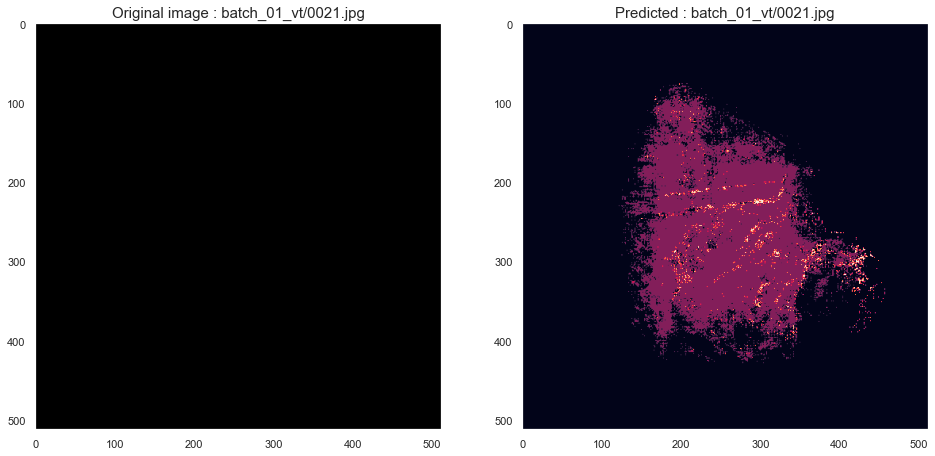

In [20]:
# 첫번째 batch의 추론 결과 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos
    temp_images = imgs
    
    model.eval()
    # inference
    outs = model(torch.stack(temp_images).to(device))
    oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
    
    break

for i in range(batch_size):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))

    print('Shape of Original Image :', list(temp_images[i].shape))
    print('Shape of Predicted : ', list(oms[i].shape))
    print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms[i]))])

    # Original image
    ax1.imshow(temp_images[i].permute([1,2,0]))
    ax1.grid(False)
    ax1.set_title("Original image : {}".format(image_infos[i]['file_name']), fontsize = 15)

    # Predicted
    ax2.imshow(oms[i])
    ax2.grid(False)
    ax2.set_title("Predicted : {}".format(image_infos[i]['file_name']), fontsize = 15)

    plt.show()

## submission을 위한 test 함수 정의

In [21]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(256, 256)])
    print('Start prediction.')
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(test_loader):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))
            oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(temp_images), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)

            oms = np.array(temp_mask)
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [22]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv(f"./submission/{model_name}.csv", index=False)

Start prediction.
End prediction.


## Reference

